In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

df = pd.read_csv("Dataset_ecommerce.csv", encoding='ISO-8859-1')
# Preview the data
df.head()


,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


# Data Cleaning




In [5]:
# Show full structure of the dataset

# 1. Total number of rows and columns
print("Dataset Shape (Rows, Columns):", df.shape)

# 2. Count of null values in each column
print("\nNull Values per Column:")
print(df.isnull().sum())

# 3. Percentage of missing values (for context)
print("\nPercentage of Missing Values per Column:")
print((df.isnull().mean() * 100).round(2))

# 4. Check for duplicate rows
print("\nNumber of Duplicate Rows:", df.duplicated().sum())

Dataset Shape (Rows, Columns): (541909, 8)

Null Values per Column:
InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
Description         0
Quantity            0
UnitPrice           0
Country             0
dtype: int64

Percentage of Missing Values per Column:
InvoiceNo       0.00
InvoiceDate     0.00
CustomerID     24.93
StockCode       0.00
Description     0.00
Quantity        0.00
UnitPrice       0.00
Country         0.00
dtype: float64

Number of Duplicate Rows: 0


# CustomerID 
Since CustomerID is essential for cohort analysis because it lets us group by users, we cannot use rows where it’s missing.
We will drop those rows in the cleaning step.

In [7]:
# Drop rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])


In [9]:
df = df.reset_index(drop=True)


In [11]:
# Count of null values in each column
print("\nNull Values per Column:")
print(df.isnull().sum())


Null Values per Column:
InvoiceNo      0
InvoiceDate    0
CustomerID     0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64


# Convert Columns to Proper Data Types

Convert CustomerID from float to string (important for grouping users)

Convert InvoiceDate from text to datetime (for time-based cohorting)

In [13]:
# Convert CustomerID to string
df['CustomerID'] = df['CustomerID'].astype(str)


In [17]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [19]:
df.dtypes

InvoiceNo              object
InvoiceDate    datetime64[ns]
CustomerID             object
StockCode              object
Description            object
Quantity                int64
UnitPrice             float64
Country                object
dtype: object

#  Create TotalPrice Column

Helps in revenue-based analysis (e.g., total value per customer or cohort)

Useful if we later want to calculate monetary value in RFM or LTV analysis customer "Life time value" 


In [21]:
# Create a new column for total price (quantity * unit price)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [23]:
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()


,Quantity,UnitPrice,TotalPrice
0,65,10.23,664.95
1,95,19.61,1862.95
2,78,61.49,4796.22
3,15,24.73,370.95
4,50,38.83,1941.50


# Assigning the Cohort Month to Each Customer

For each purchase record, assign the month when that customer made their first ever purchase; this is their cohort month.

In [25]:
# Create an InvoiceMonth column_Extract the purchase month from each transaction

df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

Now we figure out the first month each customer ever purchased something.

In [27]:
# Group by customer and get their first purchase month
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')


In [75]:
df[['CustomerID', 'InvoiceDate', 'InvoiceMonth', 'CohortMonth']].head(10)


,CustomerID,InvoiceDate,InvoiceMonth,CohortMonth
0,17850.0,2010-12-01 08:26:00,2010-12,2010-12
1,17850.0,2010-12-01 08:26:00,2010-12,2010-12
2,17850.0,2010-12-01 08:26:00,2010-12,2010-12
3,17850.0,2010-12-01 08:26:00,2010-12,2010-12
4,17850.0,2010-12-01 08:26:00,2010-12,2010-12
5,17850.0,2010-12-01 08:26:00,2010-12,2010-12
6,17850.0,2010-12-01 08:26:00,2010-12,2010-12
7,17850.0,2010-12-01 08:28:00,2010-12,2010-12
8,17850.0,2010-12-01 08:28:00,2010-12,2010-12
9,13047.0,2010-12-01 08:34:00,2010-12,2010-12


# Calculate CohortIndex (Month Offset)

What is CohortIndex?
It tells us how far along a customer is in their journey:

Month 0 = when they made their first purchase (joined)

Month 1 = the next month

Month 2 = two months later

and so on...

In [31]:
# Extract year and month for both invoice and cohort dates
invoice_year = df['InvoiceMonth'].dt.year
invoice_month = df['InvoiceMonth'].dt.month

cohort_year = df['CohortMonth'].dt.year
cohort_month = df['CohortMonth'].dt.month

# Calculate difference in months
df['CohortIndex'] = (invoice_year - cohort_year) * 12 + (invoice_month - cohort_month)


In [33]:
df[['CustomerID', 'InvoiceDate', 'CohortMonth', 'InvoiceMonth', 'CohortIndex']].head(10)


,CustomerID,InvoiceDate,CohortMonth,InvoiceMonth,CohortIndex
0,17850.0,2010-12-01 08:26:00,2010-12,2010-12,0
1,17850.0,2010-12-01 08:26:00,2010-12,2010-12,0
2,17850.0,2010-12-01 08:26:00,2010-12,2010-12,0
3,17850.0,2010-12-01 08:26:00,2010-12,2010-12,0
4,17850.0,2010-12-01 08:26:00,2010-12,2010-12,0
5,17850.0,2010-12-01 08:26:00,2010-12,2010-12,0
6,17850.0,2010-12-01 08:26:00,2010-12,2010-12,0
7,17850.0,2010-12-01 08:28:00,2010-12,2010-12,0
8,17850.0,2010-12-01 08:28:00,2010-12,2010-12,0
9,13047.0,2010-12-01 08:34:00,2010-12,2010-12,0


CohortMonth: when the customer first purchased

InvoiceMonth: when this transaction occurred

CohortIndex: how many months since their first purchase
(0 = first month, 1 = second month, etc.)

# Build the Cohort Pivot Table

This is where we reshape the data to show how many customers returned in each month of their lifecycle.

In [35]:
# Group by CohortMonth and CohortIndex, then count unique customers
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# Pivot the data to get CohortMonth as rows, CohortIndex as columns
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')


In [37]:
cohort_counts.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN


This will convert cohort counts to retention percentages

In [39]:
# Get the size of each cohort (Month 0 values)
cohort_sizes = cohort_counts.iloc[:, 0]

# Divide each cell by the size of the cohort to get % retention
retention = cohort_counts.divide(cohort_sizes, axis=0).round(3)


In [41]:
retention.head(10)

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.382,0.334,0.387,0.360,0.397,0.380,0.354,0.354,0.395,0.373,0.50,0.274
2011-01,1.0,0.240,0.283,0.242,0.328,0.299,0.261,0.257,0.311,0.347,0.368,0.15,NaN
2011-02,1.0,0.247,0.192,0.279,0.268,0.247,0.255,0.282,0.258,0.313,0.092,NaN,NaN
2011-03,1.0,0.191,0.255,0.218,0.232,0.177,0.264,0.239,0.289,0.089,NaN,NaN,NaN
2011-04,1.0,0.227,0.221,0.211,0.207,0.237,0.231,0.261,0.084,NaN,NaN,NaN,NaN
2011-05,1.0,0.237,0.172,0.172,0.215,0.244,0.265,0.104,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.209,0.187,0.272,0.247,0.336,0.102,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209,0.204,0.230,0.272,0.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251,0.251,0.251,0.138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 # Creating a Retention Heatmap
to communicates retention patterns

Darker colors = lower retention

Brighter colors = strong-performing cohorts

Diagonals and fall-offs become easy to spot for stakeholders

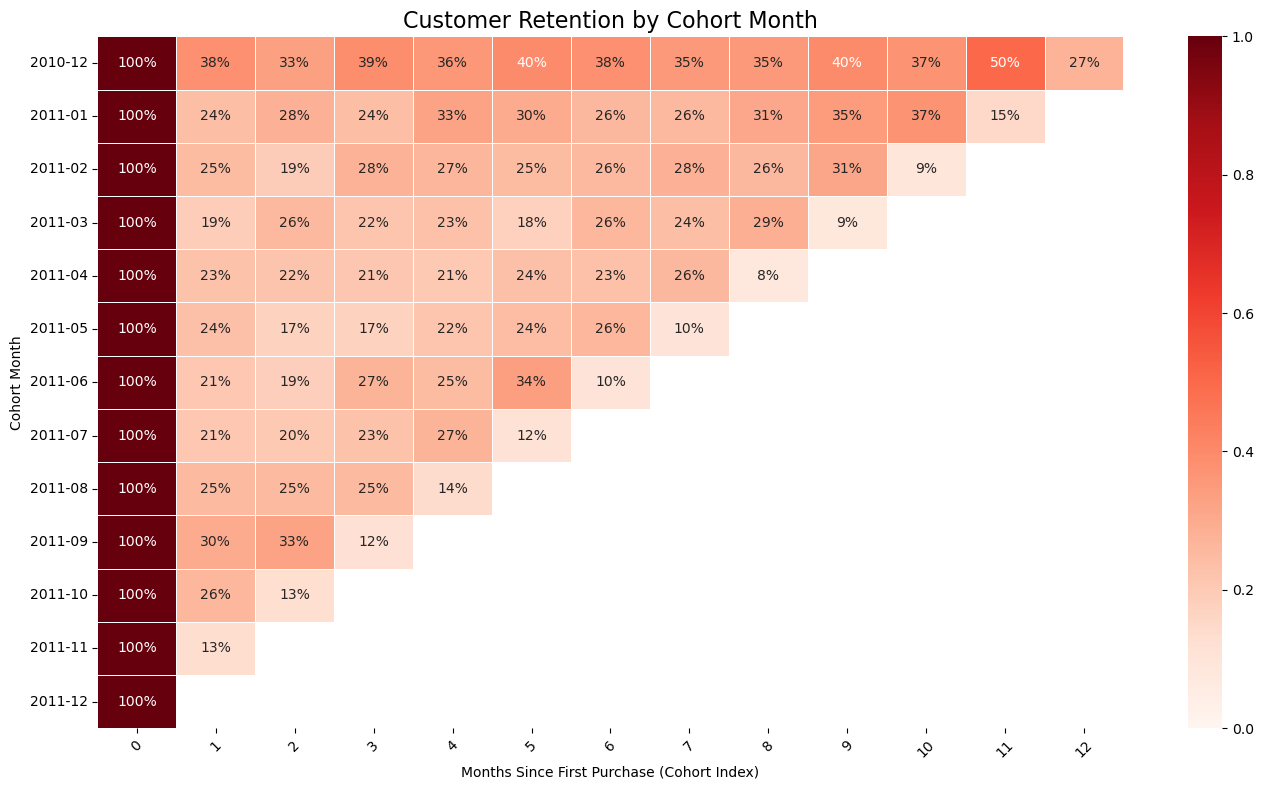

In [43]:
# Plot and save properly
plt.figure(figsize=(14, 8))
plt.title('Customer Retention by Cohort Month', fontsize=16)

sns.heatmap(
    retention,
    annot=True,
    fmt='.0%',
    cmap='Reds',
    vmin=0.0,
    vmax=1.0,
    linewidths=0.5,
    linecolor='white'
)

plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()

# 🟢 Save BEFORE showing
plt.savefig("cohort_retention_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Extracting Insights from Retention Heatmap

Insight 1: Major Drop-off After First Purchase

Most cohorts drop from 100% to 20–30% retention immediately after Month 0
This means a significant number of new customers don’t return after their first purchase.

Business Impact:
Marketing spend is likely being wasted on one-time buyers.

 Recommendation:
Explore improving onboarding, loyalty programs, or first-time buyer incentives.

Insight 2: Some Cohorts Retain Better Than Others
Example: The 2010-12 cohort maintains ~35–50% retention over several months better than others.

Business Impact:
There may have been a successful campaign, season, or promo driving not just acquisition, but long-term value.

 Recommendation:
Review what worked during that time product bundles, seasonal offers, shipping policy?

Insight 3: Retention Becomes Very Sparse After Month 5–6
Very few cohorts retain beyond Month 6. Long-term loyalty seems to be missing.

Business Impact:
Customers are not developing into repeat buyers or brand advocates.

Recommendation:
Introduce subscription models, email re-engagement flows, or personalized offers post-Month 3.

Insight 4: Newer Cohorts (late 2011) Fade Quicker
Later cohorts drop off faster and have shorter retention spans (possibly 1–2 months)

Business Impact:
Could indicate quality of traffic declined or something changed in CX (e.g. site bugs, pricing, delivery)

Recommendation:
Audit recent acquisition channels + UX — not just quantity of users, but quality.





# Revenue-Based Cohort Analysis

tackling the question

Which customers are actually bringing in the most revenue and when?

Goal

Not just who returned — but who spent.


In [53]:
# Group by CohortMonth and CohortIndex to calculate total revenue
revenue_data = df.groupby(['CohortMonth', 'CohortIndex'])['TotalPrice'].sum().reset_index()

# Pivot the data: rows = CohortMonth, columns = Month Index, values = revenue
cohort_revenue = revenue_data.pivot(index='CohortMonth', columns='CohortIndex', values='TotalPrice')

# View the first few rows
cohort_revenue.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,67923671.84,27538268.56,23330157.15,31013403.23,25525592.43,32558600.97,30448510.07,30827363.07,30462831.50,38149468.30,36831892.78,58807435.39,19094216.56
2011-01,28291062.06,6086747.69,7904594.13,6149506.88,9875753.02,8457985.80,7377792.64,7489791.36,9892205.54,12918617.62,16634785.99,3960227.09,NaN
2011-02,22668452.33,3835264.23,4934335.33,6157224.12,5510927.99,5257683.36,5651058.51,6791322.35,7594749.12,7352516.47,1090223.19,NaN,NaN
2011-03,28618836.95,3774300.74,6416835.77,5889742.45,6064521.84,5387233.25,6959646.02,9088984.94,10776384.24,2463308.20,NaN,NaN,NaN
2011-04,18756293.94,3596402.67,3362373.88,3282513.32,3480438.46,5294093.57,4852980.34,5586913.91,1361450.36,NaN,NaN,NaN,NaN


In [55]:
# Calculate total revenue per cohort across all lifecycle months
cohort_revenue['TotalRevenue'] = cohort_revenue.sum(axis=1)

# Sort the DataFrame by total revenue descending
cohort_revenue_sorted = cohort_revenue.sort_values(by='TotalRevenue', ascending=False)

# Optional: Drop 'TotalRevenue' column if you only want the cohort matrix
# cohort_revenue_sorted = cohort_revenue_sorted.drop(columns='TotalRevenue')

# Preview top-performing cohorts
cohort_revenue_sorted.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12,TotalRevenue
CohortMonth,,,,,,,,,,,,,,
2010-12,67923671.84,27538268.56,23330157.15,31013403.23,25525592.43,32558600.97,30448510.07,30827363.07,30462831.50,38149468.30,36831892.78,58807435.39,19094216.56,4.525114e+08
2011-01,28291062.06,6086747.69,7904594.13,6149506.88,9875753.02,8457985.80,7377792.64,7489791.36,9892205.54,12918617.62,16634785.99,3960227.09,NaN,1.250391e+08
2011-03,28618836.95,3774300.74,6416835.77,5889742.45,6064521.84,5387233.25,6959646.02,9088984.94,10776384.24,2463308.20,NaN,NaN,NaN,8.543979e+07
2011-02,22668452.33,3835264.23,4934335.33,6157224.12,5510927.99,5257683.36,5651058.51,6791322.35,7594749.12,7352516.47,1090223.19,NaN,NaN,7.684376e+07
2011-04,18756293.94,3596402.67,3362373.88,3282513.32,3480438.46,5294093.57,4852980.34,5586913.91,1361450.36,NaN,NaN,NaN,NaN,4.957346e+07


# Display in bar chart

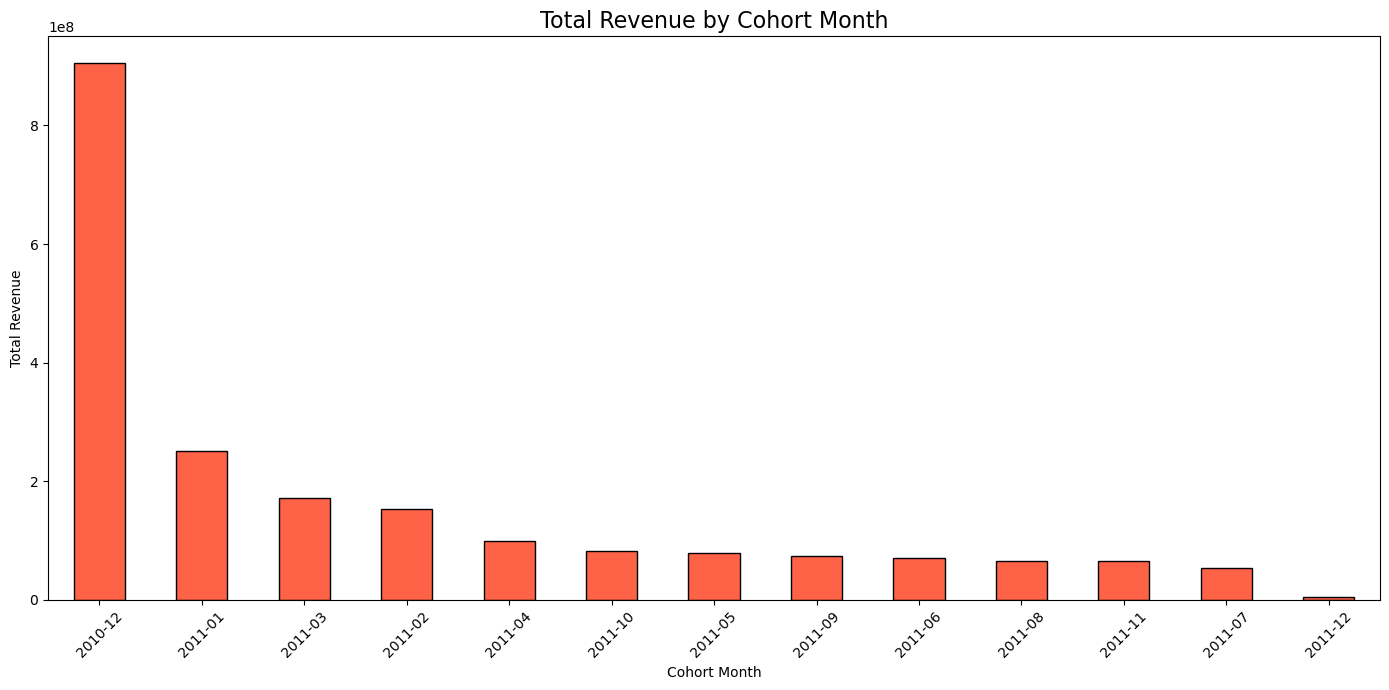

In [58]:


# Recalculate total revenue just in case
cohort_revenue['TotalRevenue'] = cohort_revenue.sum(axis=1)

# Sort by total revenue (just like before)
cohort_revenue_sorted = cohort_revenue.sort_values(by='TotalRevenue', ascending=False)

# Plot
plt.figure(figsize=(14, 7))
plt.title('Total Revenue by Cohort Month', fontsize=16)

# Create the bar plot
cohort_revenue_sorted['TotalRevenue'].plot(
    kind='bar',
    color='tomato',
    edgecolor='black'
)

plt.ylabel('Total Revenue')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ARPU — Average Revenue Per User

Helps compare cohort quality regardless of size

Smaller cohort with high ARPU? =  high-value customers

Big cohort with low ARPU? =  lots of low spend

In [61]:
# Get total revenue per cohort (i already did this)
total_revenue_per_cohort = df.groupby('CohortMonth')['TotalPrice'].sum()

# Get total unique customers per cohort
unique_customers_per_cohort = df.groupby('CohortMonth')['CustomerID'].nunique()

# Calculate ARPU
arpu_per_cohort = (total_revenue_per_cohort / unique_customers_per_cohort).round(2)

# View ARPU
arpu_per_cohort.sort_values(ascending=False).head()


CohortMonth
2010-12    477332.71
2011-01    297004.92
2011-02    202220.41
2011-08    197094.02
2011-03    194181.35
Freq: M, dtype: float64

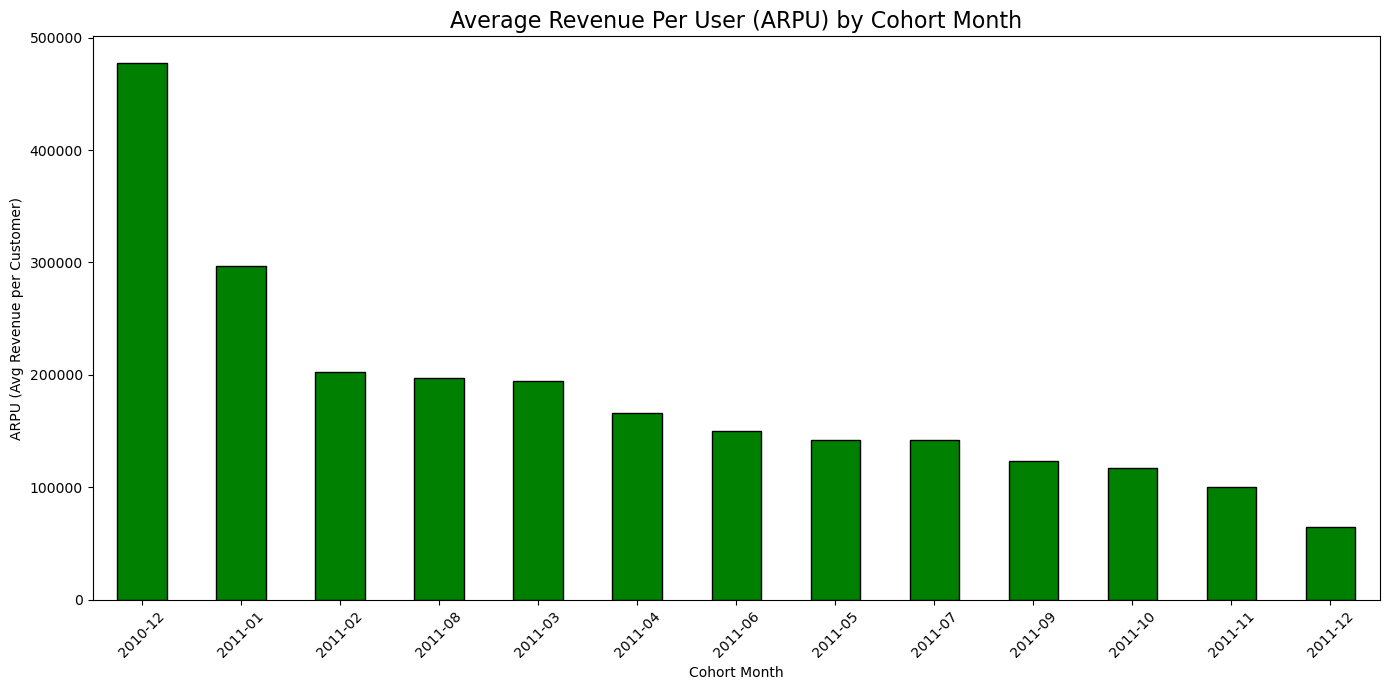

In [63]:
# Sort ARPU values descending for cleaner bar chart
arpu_sorted = arpu_per_cohort.sort_values(ascending=False)

plt.figure(figsize=(14, 7))
plt.title('Average Revenue Per User (ARPU) by Cohort Month', fontsize=16)

arpu_sorted.plot(kind='bar', color='green', edgecolor='black')

plt.ylabel('ARPU (Avg Revenue per Customer)')
plt.xlabel('Cohort Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# RFM Segmentation; Recency, Frequency, Monetary
This will help E-Shop Pro

Identify VIPs, At-risk, One-time, and High-spending customers

Design personalized marketing campaigns

Prioritize retention efforts where they count most

In [69]:
# 1. Reference date (latest in dataset)
latest_date = df['InvoiceDate'].max()

# 2. RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'TotalPrice': 'sum'                                     # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,5342.40
12347.0,1,7,431501.00
12348.0,74,4,82378.47
12349.0,18,1,176075.12
12350.0,309,1,48173.37


# Score Each Customer (1–5) on R, F, and M

Turn raw values (Recency, Frequency, Monetary) into scores from 1 to 5 for easier segmentation and interpretation.

This makes it easier to group customers like:

“5-5-5” =  Best of the best

“1-1-1” =  Cold, inactive

In [73]:
# Score Recency — lower is better (more recent = 5)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Score Frequency — higher is better (more purchases = 5)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Score Monetary — higher is better (more money spent = 5)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)


In [75]:
# Display the first few rows of the RFM table with scores
rfm[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score']].head(10)


,Recency,Frequency,Monetary,R_score,F_score,M_score
CustomerID,,,,,,
12346.0,325,2,5342.40,1,2,1
12347.0,1,7,431501.00,5,4,5
12348.0,74,4,82378.47,2,3,3
12349.0,18,1,176075.12,4,1,4
12350.0,309,1,48173.37,1,1,2
12352.0,35,11,241567.46,3,5,4
12353.0,203,1,4357.89,1,1,1
12354.0,231,1,161522.49,1,1,4
12355.0,213,1,37648.28,1,1,2


In [81]:
# Top performers
rfm.sort_values(by=['R_score', 'F_score', 'M_score'], ascending=False).head(10)

,Recency,Frequency,Monetary,R_score,F_score,M_score
CustomerID,,,,,,
12362.0,2,13,688511.11,5,5,5
12417.0,2,12,532728.74,5,5,5
12437.0,1,19,517110.85,5,5,5
12471.0,1,49,1351390.04,5,5,5
12476.0,0,20,671115.80,5,5,5
12490.0,4,10,630004.55,5,5,5
12524.0,8,8,389618.30,5,5,5
12553.0,7,14,521494.22,5,5,5
12569.0,1,35,477301.68,5,5,5


In [83]:
# Low value or at-risk customers:

rfm.sort_values(by=['R_score', 'F_score', 'M_score']).head(10)

,Recency,Frequency,Monetary,R_score,F_score,M_score
CustomerID,,,,,,
12353.0,203,1,4357.89,1,1,1
12361.0,286,1,30437.80,1,1,1
12373.0,310,1,28312.37,1,1,1
12401.0,302,1,17283.40,1,1,1
12489.0,335,1,30462.03,1,1,1
12503.0,337,1,984.60,1,1,1
12505.0,300,1,4735.36,1,1,1
12515.0,352,1,26832.80,1,1,1
12551.0,357,1,25556.19,1,1,1


#  Insight Extraction  RFM Segmentation

# Top Performers (R=5, F=5, M=5)

These are our VIPs, power buyers, and brand advocates.

What they have in common:

Buy very recently (Recency = 0–4)

Buy very often (10+ transactions)

Spend a LOT some over 1 million

 Business Impact:
These customers are our revenue engine. They don’t just buy  they keep buying, and at a high value.

Actionable Recommendations:

Exclusive perks: Give them early access, VIP deals, loyalty points

Upselling: Recommend premium products they already trust the brand

Referral Programs: These are the customers who might actually bring in others

Example: CustomerID 12471.0 made 49 purchases, spent over 1.3 million, and is still active — that’s royalty 👑

# Low Performers (R=1, F=1, M=1)

These are at-risk or lost customers.

Common traits:

Haven’t bought in 200–350+ days

Made just 1 purchase

Spent very little, as low as $984.60

Business Impact:
You spent money to acquire them, but they didn’t stay  low ROI customers.

Actionable Recommendations:

Win-back campaigns: Offer a “We miss you” discount or special promotion

Feedback survey: Try to understand what went wrong  price? product? delivery?

Exclude from high-cost ads: Don’t waste remarketing budget unless they re-engage

Example: CustomerID 12503.0 spent less than $1,000, didn’t come back, and hasn’t interacted in almost a year.

more Observations:

Recency is KING: our top spenders also bought recently the most valuable customers are also the most engaged.

Frequency ≠ monetary always: Some customers only bought once but spent big (they could be whales, but you don’t retain them).

Top customers are loyal and active  double down on what’s keeping them happy.

# Summary for Stakeholders:

Using RFM segmentation, we identified a group of high-value, loyal customers who are responsible for the bulk of our revenue. These customers are

highly engaged and should be protected and nurtured.

On the flip side, we also found a group of low-engagement, low-spend users who churned after just one interaction  suggesting wasted acquisition spend.

We recommend launching targeted win-back campaigns for at-risk users and VIP-focused experiences for top buyers to improve retention and LTV.

# Now let visualize in a chart

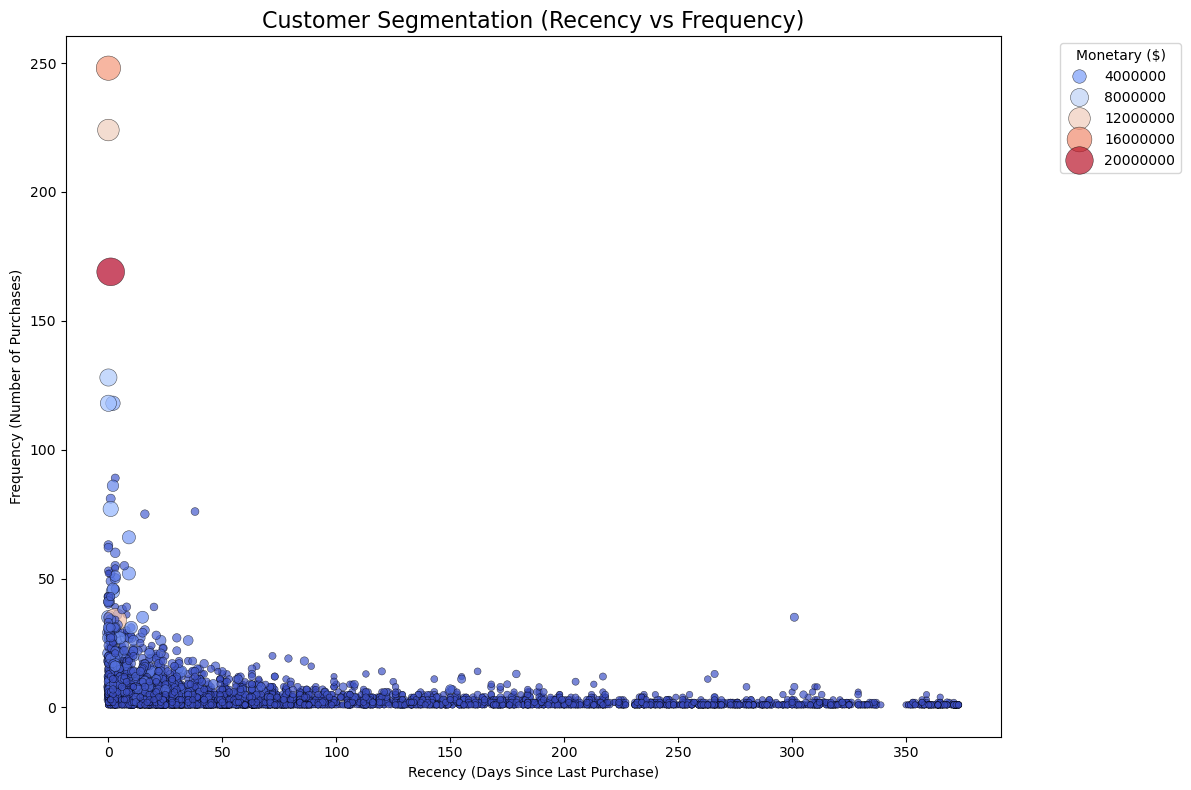

In [96]:

# Set the size and style
plt.figure(figsize=(12, 8))
plt.title('Customer Segmentation (Recency vs Frequency)', fontsize=16)

# Create the scatter plot
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Frequency',
    hue='Monetary',
    size='Monetary',
    palette='coolwarm',
    sizes=(20, 400),
    alpha=0.7,
    edgecolor='black'
)

plt.xlabel('Recency (Days Since Last Purchase)')
plt.ylabel('Frequency (Number of Purchases)')
plt.legend(title='Monetary ($)', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()


# what you see from the chart above

Top-right = active, frequent buyers (likely VIPs)

Bottom-left = inactive, one-time users (churn)

Bubble size = how much money they spent (Monetary)

In [93]:
rfm.describe()


,Recency,Frequency,Monetary,R_score,F_score,M_score
count,4372.000000,4372.000000,4.372000e+03,4372.000000,4372.000000,4372.000000
mean,91.047118,5.075480,2.372909e+05,3.010522,3.000000,3.000000
std,100.765435,9.338754,5.944603e+05,1.416276,1.414699,1.414699
min,0.000000,1.000000,1.736000e+01,1.000000,1.000000,1.000000
25%,16.000000,1.000000,4.350893e+04,2.000000,2.000000,2.000000
50%,49.000000,3.000000,1.066925e+05,3.000000,3.000000,3.000000
75%,142.000000,5.000000,2.599154e+05,4.000000,4.000000,4.000000
max,373.000000,248.000000,2.038383e+07,5.000000,5.000000,5.000000


# let interprete to what stakeholders will understand

Stakeholders don’t think in 5-5-5 or 2-3-4…

They think in terms like:

“Who are our VIPs?”

“Who’s at risk?”

“Which customers are lost or inactive?”

So let’s give them exactly that.

In [115]:
# Create Segment Tags Based on RFM Scores

rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Define Segment Categories (Business Tags)

def segment_customer(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    if r >= 4 and f >= 4 and m >= 4:
        return ' Champions'
    elif r >= 4 and f >= 2:
        return 'Loyal Customers'
    elif r >= 3 and f >= 3:
        return ' Potential Loyalist'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r >= 2 and f <= 2:
        return ' About To Sleep'
    elif r == 3 and f == 1:
        return ' Need Attention'
    elif r <= 2 and f >= 3:
        return ' At Risk'
    elif r <= 2 and f <= 2 and m <= 2:
        return ' Lost'
    else:
        return ' Other'

# let apply the Function to Label Each Customer
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


In [117]:
rfm[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score', 'Segment']].head(15)


,Recency,Frequency,Monetary,R_score,F_score,M_score,Segment
CustomerID,,,,,,,
12346.0,325,2,5342.40,1,2,1,Lost
12347.0,1,7,431501.00,5,4,5,Champions
12348.0,74,4,82378.47,2,3,3,At Risk
12349.0,18,1,176075.12,4,1,4,New Customers
12350.0,309,1,48173.37,1,1,2,Lost
12352.0,35,11,241567.46,3,5,4,Potential Loyalist
12353.0,203,1,4357.89,1,1,1,Lost
12354.0,231,1,161522.49,1,1,4,Other
12355.0,213,1,37648.28,1,1,2,Lost


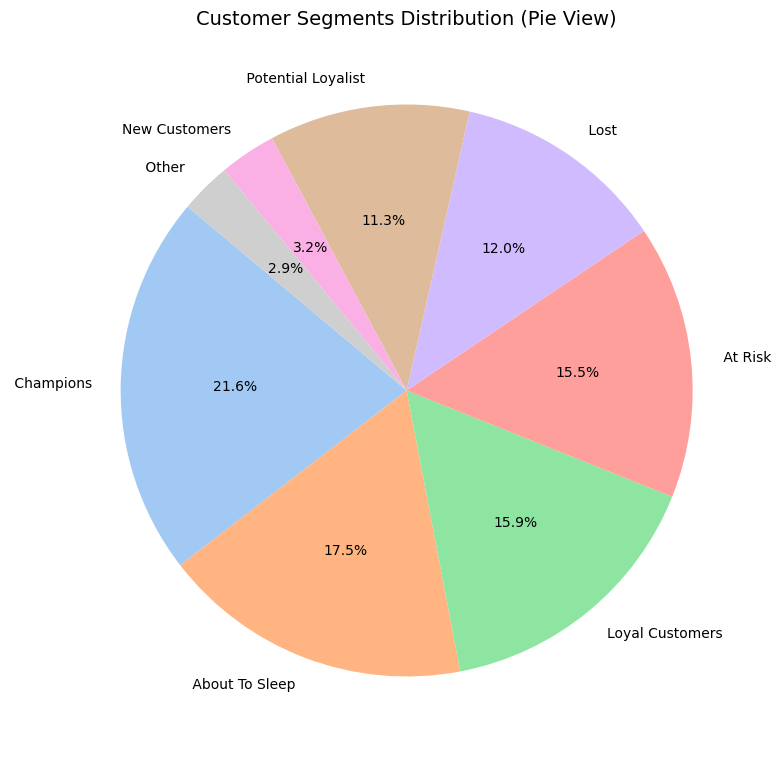

In [121]:
# Pie chart version
plt.figure(figsize=(8, 8))
plt.title('Customer Segments Distribution (Pie View)', fontsize=14)

segment_counts.plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    startangle=140
)

plt.ylabel('')
plt.tight_layout()
plt.show()
